In [1]:
import pandas as pd
import os

In [ ]:
from sso_tools import catalogs
from sso_tools import lightcurves as lcc
from sso_tools import ztf

In [ ]:
ddir = "../../../../../../projects/sso-lc/notebooks/july_16_2019/"

query_db = False
alert_filename = 'ztf_alert_sso.csv'
if query_db:
  # IF YOU WANT TO QUERY DB ON EPYC: (but if you don't, skip to next cell)
  # Get (all solar system object) alert data. 
  all_sso = ztfdb.fetch_alert_data()
  print("Total SSO alerts", len(all_sso))
  print("Number of different objects", len(all_sso.groupby('ssnamenr')))
  print("Number of nights included", len(all_sso.groupby('nid')))
  all_sso[0:5]
  all_sso.to_csv(alert_filename, index=False)
  
else:
  # Read the saved file from disk.
  all_sso2 = pd.read_csv(os.path.join(ddir, alert_filename), low_memory=False)

In [4]:
alertdata = ztf.read_alert_datafile("../../../../../../projects/sso-lc/notebooks/july_16_2019/ztf_alert_sso.csv")

In [5]:
# Identify the moving objects which are likely to be good targets for lightcurve determination.
objnames = ztf.identify_candidates(all_sso2, min_obs=50, dist_cutoff=10)
print(len(objnames), objnames[0:3])
with open('objnames.dat', 'w') as w:
    for obj in objnames:
        print(obj, file=w)

23260 ['86324' '52006' '19010']


In [8]:
cols = all_sso2.columns.values

In [9]:
cols[0] = 'name'

In [10]:
all_sso2.columns = cols

In [11]:
list(all_sso2.columns.values)

['name',
 'jd',
 'fid',
 'pid',
 'diffmaglim',
 'programid',
 'candid',
 'isdiffpos',
 'tblid',
 'nid',
 'rcid',
 'field',
 'xpos',
 'ypos',
 'ra',
 'decl',
 'magpsf',
 'sigmapsf',
 'chipsf',
 'magap',
 'sigmagap',
 'distnr',
 'magnr',
 'sigmagnr',
 'chinr',
 'sharpnr',
 'sky',
 'magdiff',
 'fwhm',
 'classtar',
 'mindtoedge',
 'magfromlim',
 'seeratio',
 'aimage',
 'bimage',
 'aimagerat',
 'bimagerat',
 'elong',
 'nneg',
 'nbad',
 'rb',
 'ssdistnr',
 'ssmagnr',
 'ssnamenr',
 'sumrat',
 'magapbig',
 'sigmagapbig',
 'ranr',
 'decnr',
 'sgmag1',
 'srmag1',
 'simag1',
 'szmag1',
 'sgscore1',
 'distpsnr1',
 'ndethist',
 'ncovhist',
 'jdstarthist',
 'jdendhist',
 'scorr',
 'tooflag',
 'objectidps1',
 'objectidps2',
 'sgmag2',
 'srmag2',
 'simag2',
 'szmag2',
 'sgscore2',
 'distpsnr2',
 'objectidps3',
 'sgmag3',
 'srmag3',
 'simag3',
 'szmag3',
 'sgscore3',
 'distpsnr3',
 'nmtchps',
 'rfid',
 'jdstartref',
 'jdendref',
 'nframesref',
 'rbversion',
 'dsnrms',
 'ssnrms',
 'dsdiff',
 'magzpsci',

In [7]:
name = '86324'

In [ ]:
#Generate oorb-corrected magnitudes (and pull JPL database)
# Note when pulling out observations here, the only outlier rejection is based on ssdistnr
print(name)
ast = ztf.AsteroidObj(magcol='magpsf')
ast(alertdata, name, minJD=None, maxJD=None)



In [48]:
# Look at the orbit info (from JPL) - this is a pandas Series
ast.orbit

des                        68950
fullname       68950 (2002 QF15)
FORMAT                       KEP
a                           1.06
q                          0.693
e                          0.344
inc                         25.2
Omega                        236
argPeri                      255
tPeri                      58555
meanAnomaly                 40.8
epoch                      58600
H                           16.4
g                           0.15
diam                        1.65
albedo                     0.178
rot                           47
dtype: object

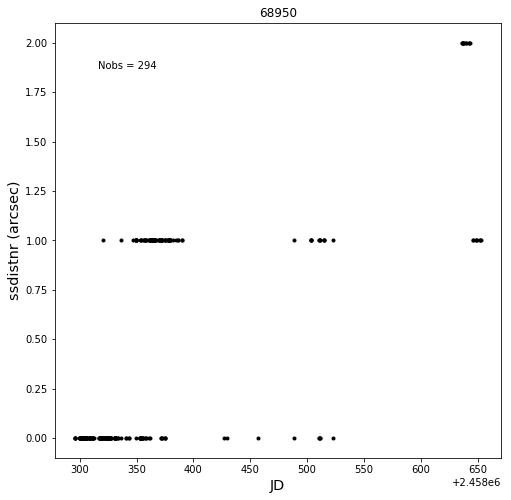

In [49]:
# Can check the ZTF predicted astrometric residuals (ssdistnr)
fig = ast.check_astrometry()

Average color r-g = -0.43


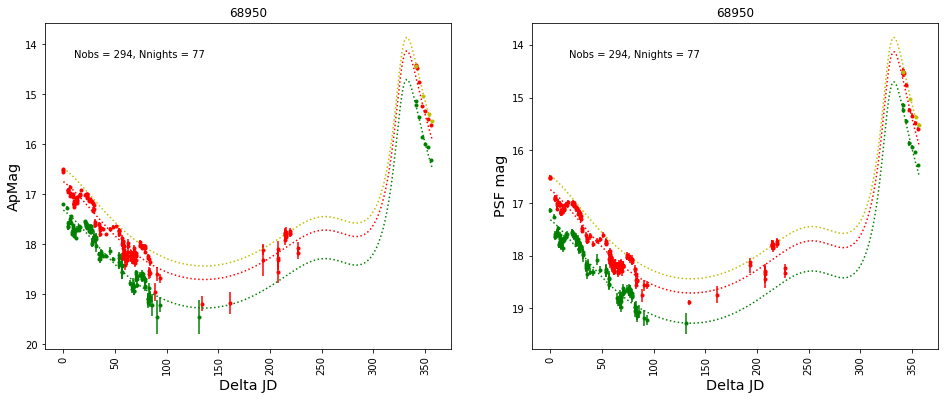

In [50]:
# Look at the photometry and oorb predicted magnitudes
fig = ast.vis_psf_ap_photometry()
# Add visualization of outlier rejection here too?



Rejected 0 observations from 68950
Finding optimal frequency:
 - Estimated peak width = 0.0176
 - Using 200 steps per peak; omega_step = 8.8e-05
 - User-specified period range:  0.042 to 2.5
 - Computing periods at 1684865 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 20 steps
Finding optimal frequency:
 - Estimated peak width = 0.0176
 - Using 200 steps per peak; omega_step = 8.8e-05
 - User-specified period range:  0.042 to 2.5
 - Computing periods at 1684865 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 40 steps
Top Periods (and doubles):
23.032 (46.064) hours
 23.498 (46.997) hours
 11.749 (23.498) hours
 23.104 (46.208) hours
 1.919 (3.838) days

Best fit period: 46.062 hours

chi2DOF 1.686512221558782


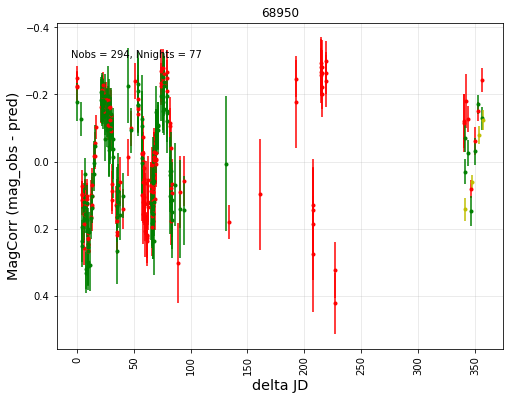

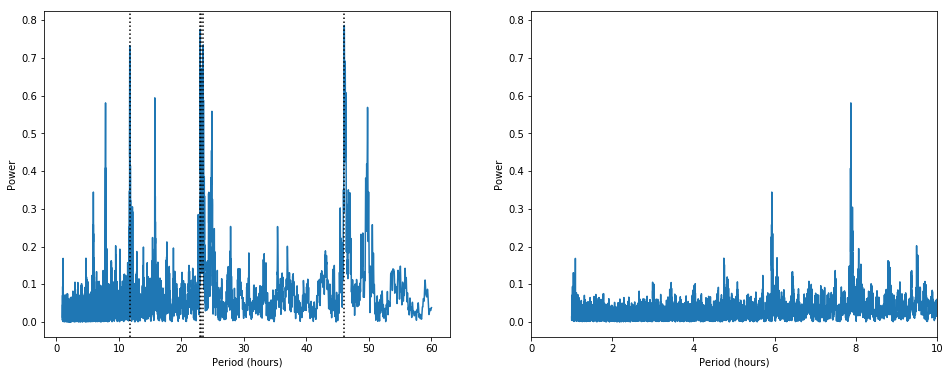

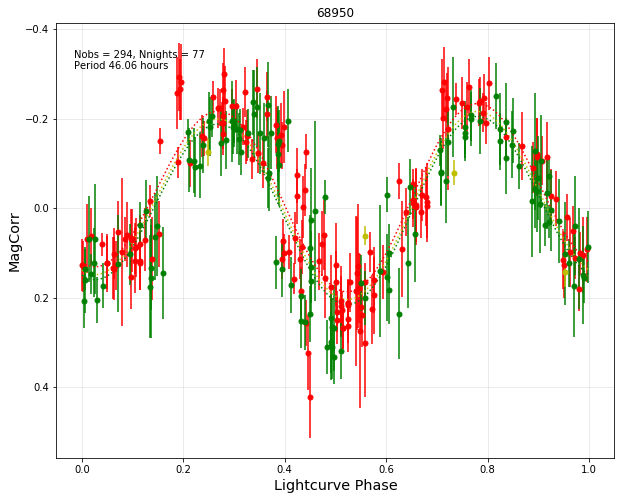

In [51]:
# Fit the lightcurve. 
lc = lcc.LCObject(min_period=1.0/24.0, max_period=60.0/24.0, 
                  nsigma=3, Nterms_base=2, Nterms_band=0)
df = ast.translate_df()
# lightcurve fitting with gatspy.periodic.LombScargleMultiband - 
# multiple band, multi-component lightcurve fitting using LS methods
figs = lc(df, ast.offsets)